In [550]:
import requests
import matplotlib
#matplotlib.use('Agg')
%matplotlib inline

import matplotlib.pyplot as plt
import psycopg2 as pg
import pandas as pd
import geopandas as gpd
import numpy as np

from fiona.crs import from_epsg
from simpledbf import Dbf5

### Data Preparation and Importing
Pulls data from a premade database used for the RAAM cost matrix

In [551]:
state = 17
counties = [7, 37, 89, 93, 99, 103, 111, 141, 201]

api_key = "5715ad9a4771612cf866aa434f979c3b00ff6eed"
year = 2013

catchment_times2 = [10, 20, 30]
weights1 = {10:1, 20:0.68, 30:0.22}
weights2 = {10:1, 20:0.42, 30:0.09}

In [552]:
# Start PostGIS connection
connection = pg.connect("""
    dbname='batch_network'
    user='snow'
    host='lab.dfsnow.me'
    password='Stonefish21'
    """)

In [553]:
# Getting counties used in the E2SFCA paper as a dataframe
counties_query="""
    SELECT * FROM counties 
    WHERE state = {0}
    AND county IN ({1})
    """.format(str(state), ', '.join(str(x).zfill(3) for x in counties))

counties_gdf = gpd.GeoDataFrame.from_postgis(
    counties_query,
    connection,
    geom_col='geom',
    crs = from_epsg(4326))

In [554]:
# Loading the PCSA files to use as doctor pops for each tract
dbf = Dbf5('t_103113_1.dbf')
pcsa_df = dbf.to_dataframe()
pcsa_df.columns = [x.lower() for x in pcsa_df.columns]
pcsa_df['geoid'] = pcsa_df['county'].astype(str) + pcsa_df['tract'].astype(str)
pcsa_df['geoid'] = pcsa_df['geoid'].astype(str)

In [555]:
# Getting tracts data to use as proxy for physician locations
# Includes populaton weighted centroids (used as intial point of driving time and physician locations)
tracts_query="""
    SELECT * FROM tracts 
    WHERE state = {0}
    AND county IN ({1})
    """.format(str(state), ', '.join(str(x).zfill(3) for x in counties))

tracts_gdf = gpd.GeoDataFrame.from_postgis(
    tracts_query,
    connection,
    geom_col='geom',
    crs = from_epsg(4326))

tracts_centroid_gdf = gpd.GeoDataFrame.from_postgis(
    tracts_query,
    connection,
    geom_col='centroid',
    crs = from_epsg(4326))

# Getting population from the census API
# Note: add /acs before /acs5? for years before 2015
tracts_gdf['pop'] = 0
for idx, k in tracts_gdf.iterrows():
    tracts_gdf.at[idx, 'pop'] = requests.get(
        'https://api.census.gov/data/' + str(year) +
        '/acs5?get=B01001_001E&for=tract:' + str(k['tract']).zfill(6) +
        '&in=state:' + str(k['state']) + '%20county:' + str(k['county']).zfill(3) +
        '&key=' + api_key).json()[1][0]    
    
tracts_gdf['geoid'] = tracts_gdf['geoid'].astype(str)
tracts_gdf = tracts_gdf.merge(pcsa_df[['geoid', 'tg_doc']], on='geoid', how='left')
tracts_gdf['geoid'] = tracts_gdf['geoid'].astype(int)

In [556]:
# Get cost matrix times for specified state
times_query="""
    SELECT * FROM times
    WHERE CAST(origin AS TEXT) LIKE '{}%'
    """.format(str(state))

times_df = pd.read_sql_query(
    times_query,
    connection)

### Enhanced Two-step Floating Catchment Area

#### Step 1

The catchment of physician location $j$ is defined as the
area within 30-min driving zone (Lee, 1991). Within each
catchment, compute three travel time zones with minute breaks
of 0–10, 10–20 and 20–30 min (zones 1–3, respectively). Search all
population locations ($k$) that are within a threshold travel time
zone ($D_r$) from location $j$ (this is catchment area j), and compute
the weighted physician-to-population ratio, $R_j$, within the catchment
area as follows:

$$R_j=\frac{S_j}{\sum_{k\in(d_{kj}\in{D_r})} P_kW_r}$$

where $P_k$ is the population of grid cell k falling within the
catchment $j$, $S_j$ the number of physicians at location $j$, $d_{kj
}$ the travel time between $k$ and $j$, and $D_r$ the $r$-th travel time zone
($r\in{1–3}$) within the catchment. $W_r$ is the distance weight for the
rth travel time zone calculated from the Gaussian function,
capturing the distance decay of access to the physician $j$.

**Note: The variable names below follow the math presented here.**

In [557]:
### E2SFCA Step One ###
tracts_gdf['rj'] = 0.0

for j in catchment_times2:
    tracts_gdf['c' + str(j)] = 0
    tracts_gdf['c' + str(j)] = tracts_gdf['c' + str(j)].astype(object)

# For each tract, create a vector of the tract geoids whose centroid
# lies within the specified catchment area time, then save to df
for idx, k in tracts_gdf.iterrows():
    wr = 0.0
    for j in catchment_times2:   
        # Getting a list of all tracts within each catchment area, for all tracts      
        catchment = pd.Series(times_df[
            (times_df['origin'] == k['geoid']) &
            (times_df['agg_cost'] < j)]['destination']).reset_index(drop=True).tolist()
        catchment.append(k['geoid'])
        
        # Writing each catchment as a list to j column for each tract
        tracts_gdf.at[idx, 'c' + str(j)] = catchment
        
        # Getting the weighted population of each tract's catchment area
        w = sum(tracts_gdf[tracts_gdf['geoid'].isin(catchment)]['pop']) * weights1[j]
        wr += w
    
    # Calculating the overall weighted doctor ratio for each tract
    tracts_gdf.at[idx, 'rj'] = k['tg_doc'] / wr

#### Step 2
For each population location $i$, search all physician locations ($j$) that are within the 30 min travel time zone from location $i$ (that is, catchment area $i$), and sum up the physician-to-population ratios (calculated in step 1), $R_j$, at these locations as follows:

$$A_{i}^F={\sum_{j\in(d_{kj}\in{D_r})} R_jW_r}$$

where $A_{F}^i$ represents the accessibility of population at location i to
physicians, Rj the physician-to-population ratio at physician location
$j$ that falls within the catchment centered at population $i$, and $d_{ij}$ the travel time between $i$ and $j$. The same distance weights derived from the Gaussian function used in step 1 are applied to different travel time zones to account for distance decay

In [558]:
### E2SFCA Step Two ###
# Summing the weighted doctor ratios for each catchment area, then weighting by previous weights
tracts_gdf['ai'] = 0.0
for idx, k in tracts_gdf.iterrows():
    ai = 0.0
    for j in catchment_times2:
        catchment = k['c' + str(j)]
        ai += sum(tracts_gdf[tracts_gdf['geoid'].isin(catchment)]['rj']) * weights1[j]
    tracts_gdf.at[idx, 'ai'] = ai

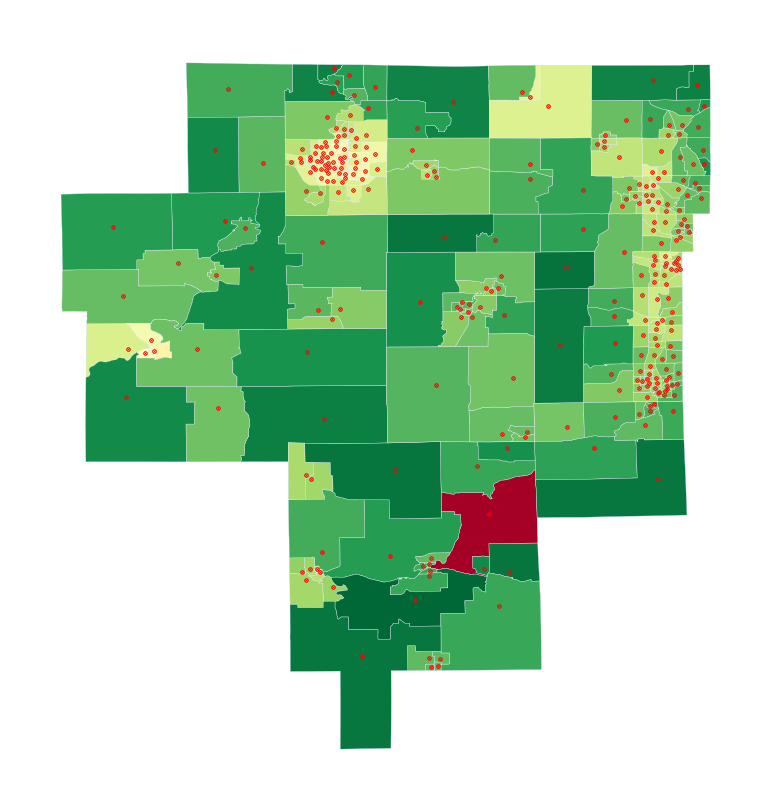

In [587]:
# Creating E2SFCA plot
fig, ax = plt.subplots(dpi=250)
ax.set_aspect('equal')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_axis_off()
ax.set_axis_on()
for a in ["bottom", "top", "right", "left"]:
    ax.spines[a].set_linewidth(0)
    
counties_gdf.plot(
    ax=ax,
    alpha=1,
    linewidth=0.1,
    edgecolor="white",
    figsize = (7, 7))

tracts_gdf.plot(
    ax=ax,
    alpha=1,
    column="ai",
    cmap="RdYlGn_r",
    linewidth=0.1,
    edgecolor="white",
    figsize = (7, 7))

tracts_centroid_gdf.plot(
    ax=ax,
    alpha=1,
    color="red",
    markersize=0.1,
    figsize = (7, 7))

![e2sfca](e2sfca.png)


### Three-step Floating Catchment Area

In [606]:
catchment_times3 = [10, 20, 30, 60]
tracts_gdf3 = tracts_gdf.copy()
w3_beta = 640

# Grabbing the Gaussian weights table from the 3SFCA paper and formatting it as a dictionary
weights3 = pd.DataFrame(data = {
'c1': [440, 0.945, 0.600, 0.242, 0.010],
'c2': [540, 0.955, 0.659, 0.314, 0.024],
'c3': [640, 0.962, 0.704, 0.377, 0.042],
'c4': [740, 0.967, 0.738, 0.430, 0.065],
'c5': [840, 0.971, 0.765, 0.475, 0.090],
'c6': [940, 0.974, 0.787, 0.514, 0.116],
'c7': [1040, 0.976, 0.805, 0.548, 0.143]
}).transpose().reset_index(drop=True)

weights3.columns = [x * 10 for x in weights3.columns]
weights3 = weights3.set_index(0)
weights3 = weights3.rename({40: 60}, axis='columns')
weights3 = weights3.to_dict('index')
weights3

{440.0: {10: 0.945, 20: 0.6, 30: 0.242, 60: 0.01},
 540.0: {10: 0.955, 20: 0.659, 30: 0.314, 60: 0.024},
 640.0: {10: 0.962, 20: 0.704, 30: 0.377, 60: 0.042},
 740.0: {10: 0.967, 20: 0.738, 30: 0.43, 60: 0.065},
 840.0: {10: 0.971, 20: 0.765, 30: 0.475, 60: 0.09},
 940.0: {10: 0.974, 20: 0.787, 30: 0.514, 60: 0.116},
 1040.0: {10: 0.976, 20: 0.805, 30: 0.548, 60: 0.143}}

In [607]:
# Creating new variables in the tracts dataframe to be filled by loops
for j in catchment_times3:
    tracts_gdf3['w' + str(j)] = 0
    tracts_gdf3['c' + str(j)] = 0
    tracts_gdf3['c' + str(j)] = tracts_gdf3['c' + str(j)].astype(object)

# For each tract, create a vector of the tract geoids whose centroid
# lies within the specified catchment area time, then save to df
for idx, k in tracts_gdf3.iterrows():
    wr = 0
    for j in catchment_times3:   
        # Getting a list of all tracts within each catchment area, for all tracts      
        catchment = pd.Series(times_df[
            (times_df['origin'] == k['geoid']) &
            (times_df['agg_cost'] < j)]['destination']).reset_index(drop=True).tolist()
        catchment.append(k['geoid'])
        
        # Writing each catchment as a list to j column for each tract
        tracts_gdf3.at[idx, 'c' + str(j)] = catchment
        
        # Getting the weighted population of each tract's catchment area (PkWr)
        w = sum(tracts_gdf3[tracts_gdf3['geoid'].isin(catchment)]['pop']) * weights3[w3_beta][j]
        tracts_gdf3.at[idx, 'w' + str(j)] = w
        

#### Step 1
3SFCA has and additional step in which the selection weight of each edge is calculated. The math is as follows:

$$G_{ij}=\frac{T_{ij}}{\sum_{k\in[Dist(i,k)<d_0]}T_{ik}}$$

where $G_{ij}$ is the selection weight between location $i$ and service site $j$, Dist($i, k$) is the travel
cost (minutes) from $i$ to any service site $k$ within the catchment, and $d_0$ is the catchment size
(i.e., driving time of 60 minutes in this study). $T_{ij}$ and $T_{ik}$ are the assigned Gaussian weights
for $j$ and $k$, respectively. This is basically the Gaussian weight of a given point divided by the summed Guassian weights of all other points in the catchment.

In [608]:
### 3SFCA Step One ###
# Adding new variables to gdf to be filled by for loops
tracts_gdf3['rj'] = 0.0
tracts_gdf3['gij'] = 0
tracts_gdf3['gij'] = tracts_gdf3['gij'].astype(object)

# This loop works by iterating through each tract, taking the total number of tracts in each catchment
# sub-zone for that tract, multiplying that total number by the correct Gaussian weight, then summing.
for idx, k in tracts_gdf3.iterrows():
    d = {}  # dictionary for storing vectors of weights and lengths
    j2 = 0  # the length of the previous vector of tracts per sub-zone
    tik = 0  # Gaussian weight of all tracts in catchment besides starting tract
    tij_list = []

    for j in catchment_times3:
        d['c' + str(j)] = len(k['c' + str(j)]) - j2
        j2 += d['c' + str(j)]
        tik += (d['c' + str(j)] * weights3[w3_beta][j])  # calculate tik
        d['tij' + str(j)] = weights3[w3_beta][j] / tik  # calculate tij
        
    tij_list.extend([d['tij' + str(j)] for i in range(j2)])
    tracts_gdf3.at[idx, 'gij'] = list(zip(k['c60'], tik_list))

#### Step 2
Determine the 60-minute catchment area of each service site $j$ and divide the catchment into four sub-zones by using the same procedure of step 1. Search all locations within the catchment and compute the physician-to-population ratio ($R$) of $j$ by:

$$R_j=\frac{S_j}{\sum_{r=1,2,3,4}\sum_{k\in{D_r}}G_{kj}P_kW_r}$$

where $S_j$ is the medical capacity of $j$, $W_r$ is the impedance of the $r$th sub-zone $D_r$, $G_{kj}$ is the
selection weight between $j$ and population site $k$, and $P_k$ is the population size of $k$.

In [609]:
# For each tract, divide the physician ratio by the sum of the weighted population multiplied by the
# summed selection weights for all tracts in the catchment zone
for idx, k in tracts_gdf3.iterrows():
    gjk_pkwr = sum(list(zip(*k['gij']))[1]) * \
          sum(k['w' + str(j)] for j in catchment_times3)
    
    tracts_gdf3.at[idx, 'rj'] = k['tg_doc'] / gjk_pkwr

#### Step 3
Compute the spatial access of population site $i$ by:

$$A_i^F=\sum_{r=1,2,3,4}\sum_{j\in{D_r}G_{ij}R_jW_r}$$

where $R_j$ is the physician-to-population ratio of $j$ within the catchment, $G_{ij}$ is the selection
weight between $i$ and $j$, and $W_r$ is the Gaussian weight of the $r$th sub-zone $D_r$.

In [610]:
### 3SFCA Step Three ###
# Summing the weighted doctor ratios for each catchment area, then weighting by previously used weights
tracts_gdf3['ai'] = 0.0
for idx, k in tracts_gdf3.iterrows():
    ai = 0.0
    gik = sum(list(zip(*k['gij']))[1])
    for j in catchment_times3:
        catchment = k['c' + str(j)]
        ai += sum(tracts_gdf3[tracts_gdf3['geoid'].isin(catchment)]['rj']) * weights3[w3_beta][j] * gik
    tracts_gdf3.at[idx, 'ai'] = ai

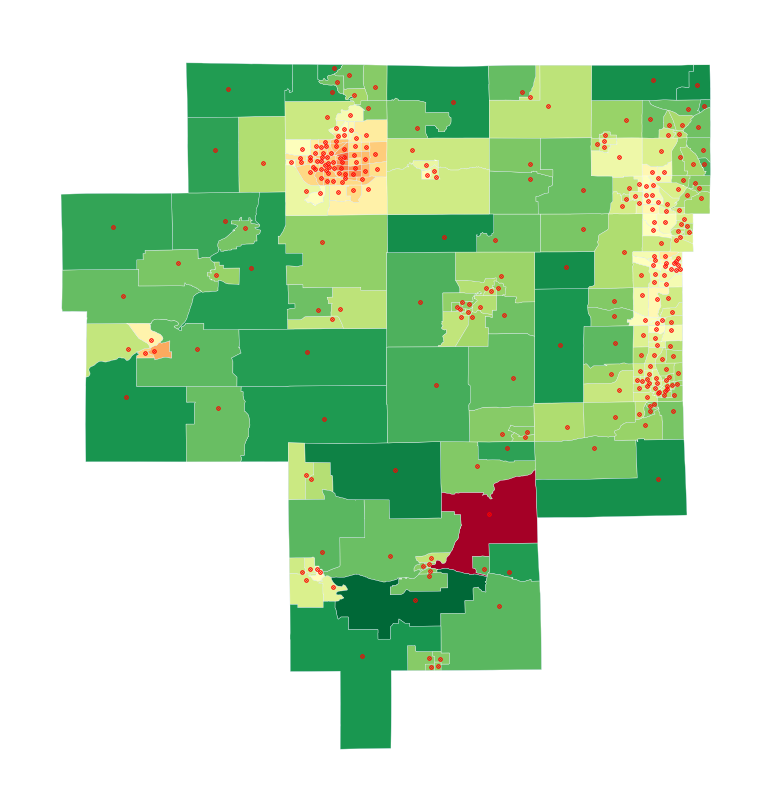

In [611]:
# Creating 3SFCA plot
fig, ax = plt.subplots(dpi=250)
ax.set_aspect('equal')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_axis_off()
ax.set_axis_on()
for a in ["bottom", "top", "right", "left"]:
    ax.spines[a].set_linewidth(0)
    
counties_gdf.plot(
    ax=ax,
    alpha=1,
    linewidth=0.1,
    edgecolor="white",
    figsize = (7, 7))

tracts_gdf3.plot(
    ax=ax,
    alpha=1,
    column="ai",
    cmap="RdYlGn_r",
    linewidth=0.1,
    edgecolor="white",
    figsize = (7, 7))

tracts_centroid_gdf.plot(
    ax=ax,
    alpha=1,
    color="red",
    markersize=0.1,
    figsize = (7, 7))